# **Transformations for Numerical Variables**

## Objectives

* To test various transformers on the numerical variables to see which one is best i.e. results in a distribution closest to normal. This will be used for ML 

## Inputs

* The csv file "US_Accidents_For_ML", which is saved locally in "Data/ML" 

## Outputs

* Understanding of which transformers to use during ML

## Summary of Steps

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Accidents_ML_Project\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Accidents_ML_Project'

---

## Required Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import skew, kurtosis
from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer, PowerTransformer
from sklearn.preprocessing import QuantileTransformer, RobustScaler, MinMaxScaler

---

## Load the Dataset

I will load the dataset using Pandas.

In [6]:
df = pd.read_csv("Data/ML/US_Accidents_For_ML.csv")
pd.set_option("display.max_columns", None)
df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Clearance_Class,Weather_Simplified,State_Other,Population,County_Other,Month
0,2,32.456486,-93.774536,0.501,Central,78.0,62.0,29.61,10.0,CALM,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Night,Very Long,Fair,LA,187540,Caddo,Sep
1,2,36.804693,-76.189728,0.253,Eastern,54.0,90.0,30.40,7.0,CALM,0.0,0.0,False,False,True,False,False,False,False,False,False,False,True,Night,Very Long,Fair,VA,459444,Virginia Beach,May
2,2,29.895741,-90.090026,1.154,Pacific,40.0,58.0,30.28,10.0,N,10.0,0.0,False,False,False,False,True,False,False,False,False,False,False,Day,Very Long,Cloudy,LA,440784,Jefferson,Jan
3,2,32.456459,-93.779709,0.016,Central,62.0,75.0,29.80,10.0,SSE,8.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Night,Very Long,Cloudy,LA,187540,Caddo,Nov
4,2,26.966433,-82.255414,0.057,Eastern,84.0,69.0,29.99,10.0,E,18.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Day,Very Long,Cloudy,FL,186824,Other,Sep


---

## Selection of Variables and Transformers

I intend to transform all numeric varaibles except "Start_Lat" and "Start_Lng". Some transformers can only handle numbers > 0, therefore I am checking which of these variables do not meet this condition.

In [10]:
# Select only numeric columns
num_cols = ["Distance(mi)", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", 
            "Wind_Speed(mph)", "Precipitation(in)", "Population"]

# Find columns that contain any negative values
zero_negative_summary = (
    (df[num_cols] <= 0)
    .sum()
    .reset_index()
    .rename(columns={"index": "Column", 0: "Negative_Count"})
)

# Keep only those columns that actually have negatives
zero_negative_summary = zero_negative_summary[zero_negative_summary["Negative_Count"] > 0]

# Display summary
if zero_negative_summary.empty:
    print("No zero or negative values found in numeric columns.")
else:
    print("Columns containing zero or negative values:")
    display(zero_negative_summary)

Columns containing zero or negative values:


,Column,Negative_Count
0,Distance(mi),2424
1,Temperature(F),27
4,Visibility(mi),10
5,Wind_Speed(mph),1765
6,Precipitation(in),9203


"Distance(mi)", "Temperature(F)", "Visibility(mi)", "Wind_Speed(mph)" and "Precipitation(in)" all have zero and/ or negative values. I will deal with these variables seperately to the rest.

---

## Transformation of Variable without Zero or Negative Values

For variables without zero or negative numbers I will be using LogTransformer", "YeoJohnsonTransformer", and "PowerTransformer" from Feature Engine.

In [11]:
def calculate_skew_kurtosis(df, col, moment):
    skewness = df[col].skew()
    kurt = df[col].kurt()
    print(f"{moment} — {col}: skew = {skewness:.3f}, kurtosis = {kurt:.3f}")

def compare_distributions_before_and_after_applying_transformer(df, df_transformed, method):
    for col in df.columns:
        print(f"*** {col} ***")
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6,5))

        sns.histplot(data=df, x=col, kde=True, ax=axes[0,0])
        axes[0,0].set_title(f'Before {method}')
        pg.qqplot(df[col], dist='norm', ax=axes[0,1])

        sns.histplot(data=df_transformed, x=col, kde=True, ax=axes[1,0])
        axes[1,0].set_title(f'After {method}')
        pg.qqplot(df_transformed[col], dist='norm', ax=axes[1,1])

        plt.tight_layout()
        plt.show()

        calculate_skew_kurtosis(df, col, 'before transformation')
        calculate_skew_kurtosis(df_transformed, col, 'after transformation')
        print("\n")

In [12]:
def collect_summary_stats(df_before, df_after, transformer_name, summary_list):
    for col in df_before.columns:
        if not pd.api.types.is_numeric_dtype(df_before[col]):
            continue  # skip non-numeric
        try:
            skew_before = skew(df_before[col].dropna())
            kurt_before = kurtosis(df_before[col].dropna())
            skew_after = skew(df_after[col].dropna())
            kurt_after = kurtosis(df_after[col].dropna())

            summary_list.append({
                "Variable": col,
                "Transformer": transformer_name,
                "Skew_before": skew_before,
                "Skew_after": skew_after,
                "Δ|Skew|": abs(abs(skew_before) - abs(skew_after)),
                "Kurtosis_before": kurt_before,
                "Kurtosis_after": kurt_after,
                "Δ|Kurtosis|": abs(abs(kurt_before) - abs(kurt_after))
            })
        except Exception as e:
            print(f"Could not compute stats for {col}: {e}")


===== Variable: Humidity(%) =====
--- Applying LogTransformer ---
*** Humidity(%) ***


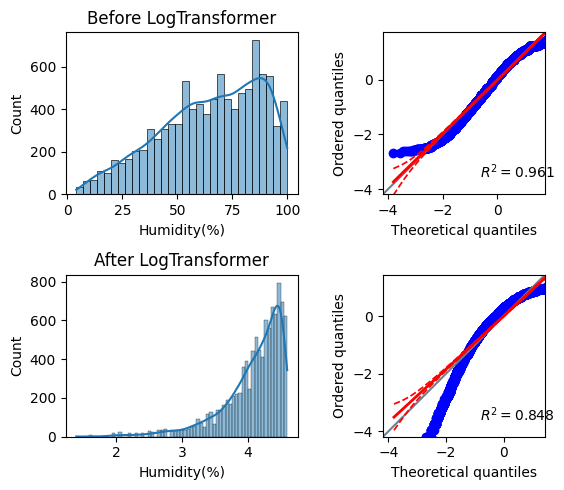

before transformation — Humidity(%): skew = -0.468, kurtosis = -0.640
after transformation — Humidity(%): skew = -1.678, kurtosis = 3.473


--- Applying YeoJohnsonTransformer ---
*** Humidity(%) ***


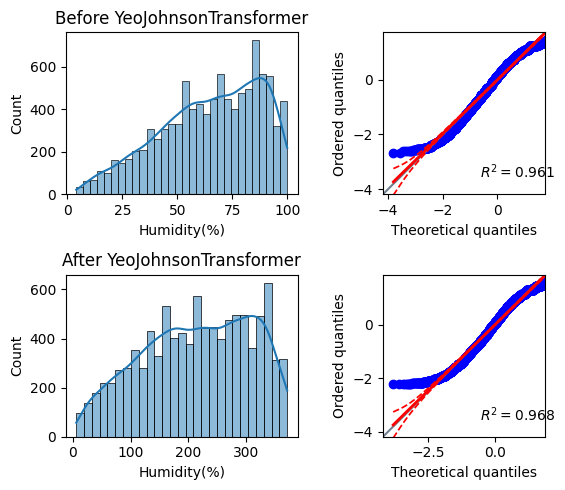

before transformation — Humidity(%): skew = -0.468, kurtosis = -0.640
after transformation — Humidity(%): skew = -0.231, kurtosis = -0.946


--- Applying PowerTransformer ---
*** Humidity(%) ***


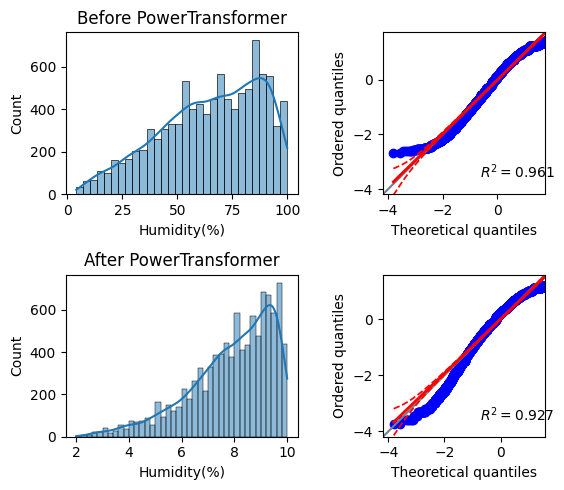

before transformation — Humidity(%): skew = -0.468, kurtosis = -0.640
after transformation — Humidity(%): skew = -0.939, kurtosis = 0.449



===== Variable: Pressure(in) =====
--- Applying LogTransformer ---
*** Pressure(in) ***


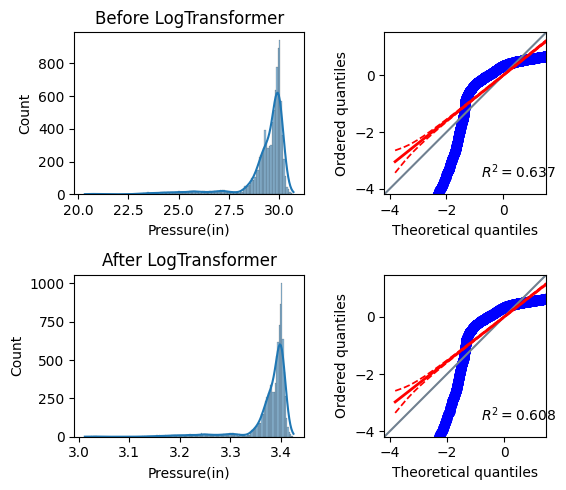

before transformation — Pressure(in): skew = -2.957, kurtosis = 9.839
after transformation — Pressure(in): skew = -3.197, kurtosis = 11.931


--- Applying YeoJohnsonTransformer ---
*** Pressure(in) ***


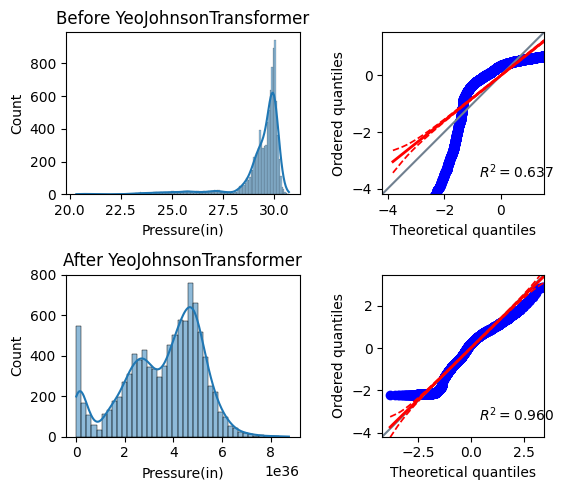

before transformation — Pressure(in): skew = -2.957, kurtosis = 9.839
after transformation — Pressure(in): skew = -0.509, kurtosis = -0.366


--- Applying PowerTransformer ---
*** Pressure(in) ***


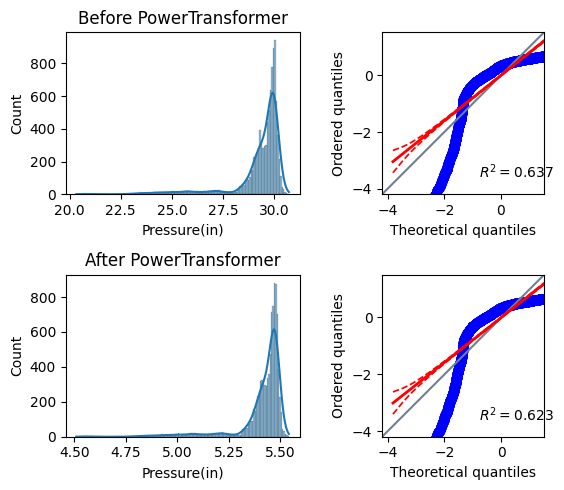

before transformation — Pressure(in): skew = -2.957, kurtosis = 9.839
after transformation — Pressure(in): skew = -3.072, kurtosis = 10.809



===== Variable: Population =====
--- Applying LogTransformer ---
*** Population ***


c:\Users\sonia\Documents\VS Studio Projects\US_Accidents_ML_Project\.venv\Lib\site-packages\feature_engine\transformation\log.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[12.14174743 13.03777234 12.99631024 ... 10.27059291 11.13654332
 14.69323675]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.log(X.loc[:, self.variables_])


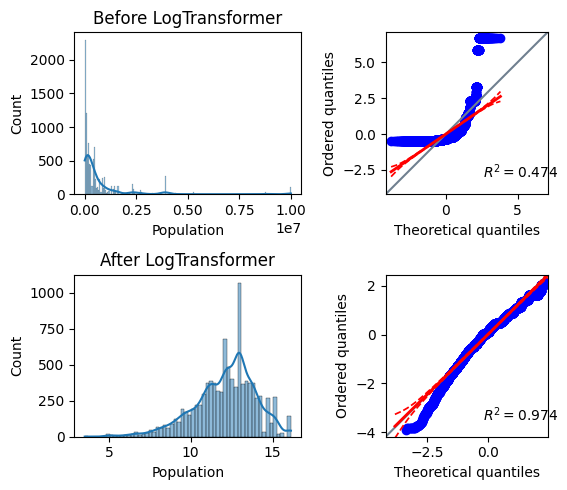

before transformation — Population: skew = 4.553, kurtosis = 24.731
after transformation — Population: skew = -0.665, kurtosis = 0.737


--- Applying YeoJohnsonTransformer ---
*** Population ***


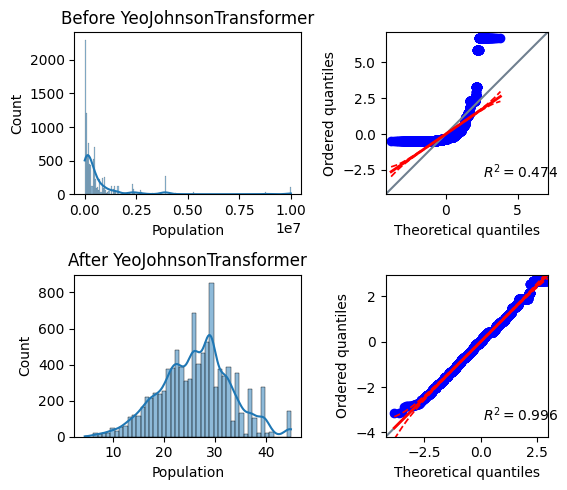

before transformation — Population: skew = 4.553, kurtosis = 24.731
after transformation — Population: skew = -0.003, kurtosis = 0.003


--- Applying PowerTransformer ---
*** Population ***


c:\Users\sonia\Documents\VS Studio Projects\US_Accidents_ML_Project\.venv\Lib\site-packages\feature_engine\transformation\power.py:147: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 433.05888745  677.82298574  663.91565729 ...  169.91468447  261.98091534
 1550.94293899]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.power(X.loc[:, self.variables_], self.exp)


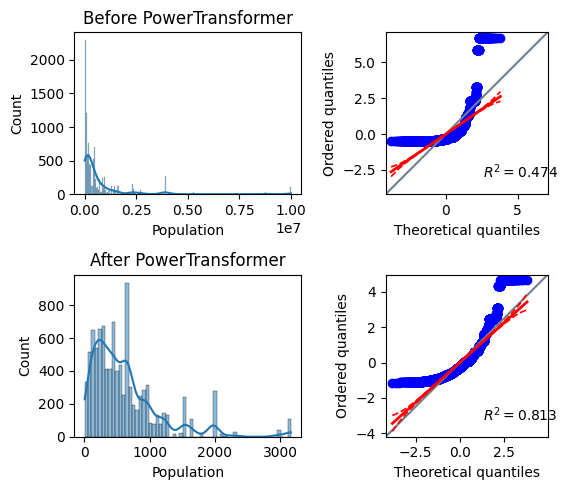

before transformation — Population: skew = 4.553, kurtosis = 24.731
after transformation — Population: skew = 2.032, kurtosis = 5.496




,Variable,Transformer,Skew_before,Skew_after,Δ|Skew|,Kurtosis_before,Kurtosis_after,Δ|Kurtosis|
0,Humidity(%),LogTransformer,-0.47,-1.68,1.21,-0.64,3.47,2.83
1,Humidity(%),PowerTransformer,-0.47,-0.94,0.47,-0.64,0.45,0.19
2,Humidity(%),YeoJohnsonTransformer,-0.47,-0.23,0.24,-0.64,-0.95,0.31
3,Population,YeoJohnsonTransformer,4.55,-0.00,4.55,24.72,0.00,24.72
4,Population,LogTransformer,4.55,-0.66,3.89,24.72,0.74,23.98
5,Population,PowerTransformer,4.55,2.03,2.52,24.72,5.49,19.22
6,Pressure(in),YeoJohnsonTransformer,-2.96,-0.51,2.45,9.83,-0.37,9.47
7,Pressure(in),LogTransformer,-2.96,-3.20,0.24,9.83,11.92,2.09
8,Pressure(in),PowerTransformer,-2.96,-3.07,0.12,9.83,10.80,0.97


In [15]:
# Columns to loop over (numeric variables)
num_cols = ["Humidity(%)", "Pressure(in)", "Population"]

# Define transformers
transformers = {
    "LogTransformer": lambda var: LogTransformer(variables=[var]),
    "YeoJohnsonTransformer": lambda var: YeoJohnsonTransformer(variables=[var]),
    "PowerTransformer": lambda var: PowerTransformer(variables=[var]),
}

summary = []

# Loop through each variable first
for var in num_cols:
    print(f"\n===== Variable: {var} =====")
    for name, transformer_func in transformers.items():
        print(f"--- Applying {name} ---")
        try:
            transformer = transformer_func(var)
            
            # Fit and transform
            df_transformed = transformer.fit_transform(df[[var]])
            
            # Plot before & after
            compare_distributions_before_and_after_applying_transformer(df[[var]], df_transformed, name)
            
            # Collect stats
            collect_summary_stats(df[[var]], df_transformed, transformer_name=name, summary_list=summary)
        
        except Exception as e:
            print(f"{name} failed for {var}: {e}")

# Create summary table
summary_df = (
    pd.DataFrame(summary)
    .sort_values(by=["Variable", "Δ|Skew|"], ascending=[True, False])
    .reset_index(drop=True)
)

numeric_cols = ["Skew_before", "Skew_after", "Δ|Skew|", "Kurtosis_before", "Kurtosis_after", "Δ|Kurtosis|"]

summary_df[numeric_cols] = summary_df[numeric_cols].apply(lambda x: x.round(2))

display(summary_df)

For each of the 3 variables, I will be using the Yeo Johnson transformer, as it gives the best performance of bringing the distrubtions closest to normal.

---

## Transformation of Variable with Zero or Negative Values

---